In [1]:
%matplotlib inline
%load_ext line_profiler
%load_ext autoreload

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import (Dense, Conv2D, Input, MaxPool2D, 
                         UpSampling2D, Concatenate, Conv2DTranspose, 
                         Dropout, Cropping2D)
import tensorflow as tf
from keras.optimizers import Adam,SGD
from keras.initializers import he_normal
from keras.models import load_model
from scipy.misc import imresize
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from skimage.measure import label as label_shape
import os
from keras.preprocessing.image import (array_to_img, img_to_array, 
                                       load_img, ImageDataGenerator)
from keras.callbacks import (Callback, ModelCheckpoint, CSVLogger, 
                             ReduceLROnPlateau, TensorBoard)
from callback2 import BatchHistory
import keras.backend as K
import itchat
from wechat_utils import SendMessage, send_text
import random
from importlib import reload
import pickle
import csv

import pdb
import gc
import sys

Using TensorFlow backend.


/home/paperspace/anaconda3/envs/tf11/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
import keras
keras.__version__

'2.0.8'

## Prepare the data

In [3]:
# Set the necessary directories
data_dir = '../data/train_hq/'
mask_dir = '../data/train_masks/'
data2_dir = '../data2/'
test_dir = '../data/test_hq/'
all_images = os.listdir(data_dir)

In [4]:
!mkdir tmp

mkdir: cannot create directory ‘tmp’: File exists


In [5]:
tmp_dir = './tmp/u-net-v5/'

In [6]:
!mkdir ./tmp/u-net-v5/

mkdir: cannot create directory ‘./tmp/u-net-v5/’: File exists


In [7]:
!mkdir ./tmp/u-net-v5/result

In [8]:
!mkdir ./tmp/u-net-v5/mask_pred

In [9]:
# Train validation split
train_images, validation_images = train_test_split(
    all_images, train_size=0.8, test_size=0.2, random_state=99)

In [10]:
# original size 1280, 1918
image_size = [1918, 1280]
input_dims = [1280, 1920]
output_dims = [1280, 1920]
batch_size = 1

In [11]:
# Utility function to convert greyscale images to rgb
def grey2rgb(img):
    new_img = []
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            new_img.append(list(img[i][j]) * 3)
    new_img = np.array(new_img).reshape(img.shape[0], img.shape[1], 3)
    return new_img

In [12]:
from data_utils import (read_image_and_mask, show_image_and_mask)

In [13]:
#%autoreload
#from data_utils import random_crop
#image_, mask_ = read_image_and_mask(data_dir, mask_dir, train_images[0])
#show_image_and_mask(image_, mask_)
#image_, mask_ = random_crop((image_, mask_), input_dims)
#show_image_and_mask(image_, mask_)
#print (image_.size)

In [14]:
%%time
image_, mask_ = read_image_and_mask(data_dir, mask_dir, train_images[0])
image_ = image_.resize(image_size, resample=Image.BILINEAR)
mask_ = mask_.resize(image_size, resample=Image.BILINEAR)

CPU times: user 60 ms, sys: 4 ms, total: 64 ms
Wall time: 80.1 ms


In [15]:
%%time
image_, mask_ = read_image_and_mask(data_dir, mask_dir, train_images[0])
image_ = imresize(image_, image_size[::-1])
mask_ = imresize(mask_, image_size[::-1])

CPU times: user 72 ms, sys: 20 ms, total: 92 ms
Wall time: 91.7 ms


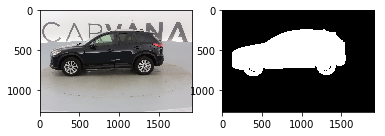

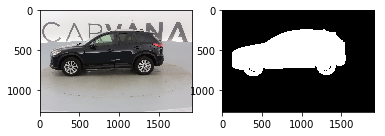

(1918, 1280)


In [16]:
from data_utils import resize_image
image_, mask_ = read_image_and_mask(data_dir, mask_dir, train_images[0])
show_image_and_mask(image_, mask_)
image_, mask_ = resize_image((image_, mask_), image_size)
show_image_and_mask(image_, mask_)
print (image_.size)

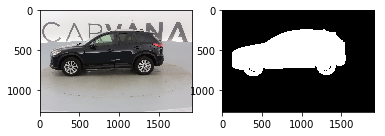

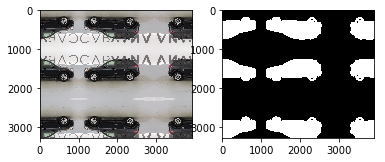

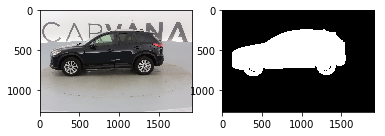

CPU times: user 268 ms, sys: 92 ms, total: 360 ms
Wall time: 359 ms


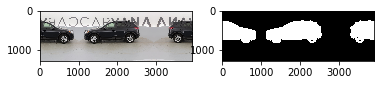

In [17]:
def pad_image_and_mask(image_pair, pad_width, mode='symmetric'):
    """
    Padding the image for prediction, the mode is 
    same as the one in numpy.pad
    
    # Args 
    image:      PIL Image or array
    pad_width:  the width to pad around the image, integer or tuple represent
                ((h, h), (w, w), (channel, channel))
    
    # Return
                PIL Image padded
    """
    image, mask = image_pair
    
    array_image = img_to_array(image)
    array_mask = img_to_array(mask)
    if type(pad_width) is int:
        padding = ((pad_width, pad_width), (pad_width, pad_width), (0, 0))
    else:
        assert type(pad_width) in [tuple, list]
        padding = pad_width
    padded_array_image = np.pad(array_image, padding, mode=mode)
    padded_array_mask = np.pad(array_mask, padding, mode=mode)
    
    padded_image = array_to_img(padded_array_image)
    padded_mask = array_to_img(padded_array_mask)
    
    return padded_image, padded_mask

image_, mask_ = read_image_and_mask(data_dir, mask_dir, train_images[0])
show_image_and_mask(image_, mask_)
image_, mask_ = pad_image_and_mask((image_, mask_), 1000)
show_image_and_mask(image_, mask_)

image_, mask_ = read_image_and_mask(data_dir, mask_dir, train_images[0])
show_image_and_mask(image_, mask_)
%time image_, mask_ = pad_image_and_mask((image_, mask_), ((0, 0), (1000, 1000), (0, 0)))
show_image_and_mask(image_, mask_)

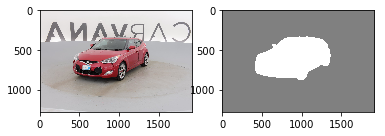

In [18]:
## from data_utils import random_horizontal_flip
from data_utils import random_horizontal_flip
from data_utils import resize_image
del globals()['resize_image']
from data_utils import resize_image

transform_resize = lambda image_pair: resize_image(image_pair, image_size)
transform_flip = lambda image_pair: random_horizontal_flip(image_pair, prob=0.5)
transform_pad = lambda image_pair: pad_image_and_mask(image_pair, ((0, 0), (1, 1), (0, 0)))
transforms = [transform_resize, transform_flip, transform_pad]

from data_utils import data_gen_small, threadsafe_iter
import data_utils
reload(data_utils)
del globals()['data_gen_small']
from data_utils import data_gen_small
            
# Example use
train_gen = data_gen_small(data_dir, mask_dir, train_images, batch_size, 
                          input_dims, transforms=transforms)
img, msk = next(train_gen)

plt.subplot(121)
plt.imshow(img[0])
plt.subplot(122)
plt.imshow(grey2rgb(msk[0]), alpha=0.5)

In [19]:
%%time
train_images_, train_masks_ = next(train_gen)

CPU times: user 280 ms, sys: 60 ms, total: 340 ms
Wall time: 349 ms


In [20]:
print (train_images_.shape)
print (train_masks_.shape)

(1, 1280, 1920, 3)
(1, 1280, 1920, 1)


In [21]:
val_gen = data_gen_small(data_dir, mask_dir, validation_images, batch_size, 
                         input_dims, transforms=transforms, in_order=True)

In [22]:
len(validation_images)

1018

In [23]:
for i in tqdm(range(10)):
    val_images, val_masks = next(val_gen)

100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


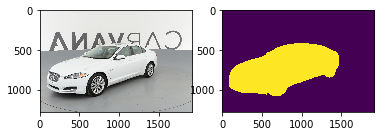

In [24]:
val_images, val_masks = next(val_gen)
show_image_and_mask(val_images[0], val_masks[0,:,:,0])

In [25]:
print (val_images.shape)
print (val_masks.shape)

(1, 1280, 1920, 3)
(1, 1280, 1920, 1)


In [26]:
image_, mask_ = next(train_gen)
print (image_.shape)
print (mask_.shape)
print (mask_[0].shape)
print (mask_.max())
print (mask_[0].sum())

(1, 1280, 1920, 3)
(1, 1280, 1920, 1)
(1280, 1920, 1)
1.0
839170.0


## Build the network

In [27]:
# First, let's define the two different types of layers that we will 
# be using
import layer_utils
from layer_utils import down,up
reload(layer_utils)
from layer_utils import down,up
def down2(input_layer, filters, pool=True, padding='same', layers=2, verbose=1):
    concat = input_layer
    conv_input = input_layer
    for i in range(layers):
        if i != 1:
            conv_input = Conv2D(filters // 2, (1, 1), padding='same', 
                                kernel_initializer=he_normal(), activation='relu')(
                                concat)
        conv = Conv2D(filters // 2, (3, 3), padding=padding, 
                          kernel_initializer=he_normal(), activation='relu')(
                          concat)
        concat = Concatenate(axis=3)([concat, conv])
    residual = Conv2D(filters, (1, 1), padding='same', 
                      kernel_initializer=he_normal(), activation='relu')(
                      concat)
        
    if pool:
        max_pool = MaxPool2D()(residual)
        if verbose:
            print ('Down output shape')
            print ('max_pool {}, residual {}'.format(K.int_shape(max_pool), K.int_shape(residual)))
        return max_pool,residual
    else:
        if verbose:
            print ('Down output shape')
            print ('residual {}'.format(K.int_shape(residual)))
        return residual
    
def up2(input_layer, residual, filters, padding='same', layers=2, cropping=0, verbose=1):
    filters=int(filters)
    upsample = UpSampling2D()(input_layer)
    upconv = Conv2D(filters, kernel_size=(2, 2), padding='same', 
                    kernel_initializer=he_normal(), activation='relu')(upsample)
    if cropping != 0:
        residual = Cropping2D(cropping=cropping)(residual)

    conv_input = Concatenate(axis=3)([residual, upconv])
    concat = conv_input
    for i in range(layers):
        if i != 1:
            conv_input = Conv2D(filters // 2, (1, 1), padding='same', 
                                kernel_initializer=he_normal(), activation='relu')(
                                concat)
        conv = Conv2D(filters // 2, (3, 3), padding=padding, 
                      kernel_initializer=he_normal(), activation='relu')(
                      conv_input)
        concat = Concatenate(axis=3)([concat, conv])
    out = Conv2D(filters, (1, 1), padding='same', 
                 kernel_initializer=he_normal(), activation='relu')(
                 concat)
    
    if verbose:
        print ('Up output dims')
        print (K.int_shape(out))
    return out

In [52]:
%autoreload
from layer_utils import down_block, up_block
def down_block2(input_layer, filters_list, layers_list, 
                dropout_list=None, padding='same'):
    residuals = []
    out = input_layer
    
    if dropout_list is None:
        dropout_list = [0] * len(filters_list)
    
    for i,filters in enumerate(filters_list):
        out, res = down2(out, filters, layers=layers_list[i], pool=True, padding=padding)
        residuals.append(res)
        if dropout_list[i] > 0:
            out = Dropout(dropout_list[i])(out)
    return out, residuals

def up_block2(input_layer, residuals, filters_list, layers_list, 
              dropout_list=None, padding='same', cropping=None):
    out = input_layer
    
    if padding == 'same':
        cropping = [0] * len(filters_list)
    if dropout_list is None:
        dropout_list = [0] * len(filters_list)
    
    for i, filters in enumerate(filters_list):
        out = up2(out, residuals[::-1][i], filters, layers=layers_list[i],
                 padding=padding, cropping=cropping[i])
        if dropout_list[i] > 0:
            out = Dropout(dropout[i])(out)
    return out

In [29]:
%autoreload
K.clear_session()
filters_list_down1 = [24, 48, 96, 172]
filters_list_down2 = [24, 48, 96]
filters_list_up1 = [32, 64, 128, 256][::-1]
filters_list_up2 = [24, 48, 96][::-1]
layers_list_down1 = [2, 2, 2, 2]
layers_list_down2 = [2, 2, 2, 2]
layers_list_up2 = [2, 2, 2, 2][::-1]
layers_list_up1 = [2, 2, 3, 3][::-1]
dropout_list = None
dropout_list = [0, 0, 0, 0.5]

input_layer = Input(shape=[None, None] + [3])
out, residuals1 = down_block2(input_layer, filters_list_down1, layers_list_down1, dropout_list)
out, residuals2 = down_block2(out, filters_list_down2, layers_list_down2, dropout_list)

out = down2(out, 172, layers=2, pool=False)
out = Dropout(0.5)(out)
out = up_block2(out, residuals2, filters_list_up2, layers_list_up2)
out = up_block2(out, residuals1, filters_list_up1, layers_list_up1)

out = Conv2D(filters=1, kernel_size=(1, 1), kernel_initializer=he_normal(), 
             activation='sigmoid', padding='same')(out)

model = Model(input_layer, out)
model.summary()

Down output shape
max_pool (None, None, None, 24), residual (None, None, None, 24)
Down output shape
max_pool (None, None, None, 48), residual (None, None, None, 48)
Down output shape
max_pool (None, None, None, 96), residual (None, None, None, 96)
Down output shape
max_pool (None, None, None, 172), residual (None, None, None, 172)
Down output shape
max_pool (None, None, None, 24), residual (None, None, None, 24)
Down output shape
max_pool (None, None, None, 48), residual (None, None, None, 48)
Down output shape
max_pool (None, None, None, 96), residual (None, None, None, 96)
Down output shape
residual (None, None, None, 172)
Up output dims
(None, None, None, 96)
Up output dims
(None, None, None, 48)
Up output dims
(None, None, None, 24)
Up output dims
(None, None, None, 256)
Up output dims
(None, None, None, 128)
Up output dims
(None, None, None, 64)
Up output dims
(None, None, None, 32)
__________________________________________________________________________________________________

In [53]:
K.clear_session()
filters_list_1 = [48, 96, 192, 384]
filters_list_2 = [36, 72, 144]

input_layer = Input(shape=[None, None, 3])
out, residuals_1 = down_block(input_layer, filters_list_1)
out, residuals_2 = down_block(out, filters_list_2)
out = down(out, 288, pool=False)
out = down(out, 36, pool=False)
out = down(out, 288, pool=False)
out = up_block(out, residuals_2, filters_list_2[::-1])
out = up_block(out, residuals_1, filters_list_1[::-1])
out = Conv2D(filters=1, kernel_size=(1, 1), kernel_initializer=he_normal(),
             activation='sigmoid', padding='same')(out)

model = Model(input_layer, out)
model.summary()

Down output shape
max_pool (None, None, None, 48), residual (None, None, None, 48)
Down output shape
max_pool (None, None, None, 96), residual (None, None, None, 96)
Down output shape
max_pool (None, None, None, 192), residual (None, None, None, 192)
Down output shape
max_pool (None, None, None, 384), residual (None, None, None, 384)
Down output shape
max_pool (None, None, None, 36), residual (None, None, None, 36)
Down output shape
max_pool (None, None, None, 72), residual (None, None, None, 72)
Down output shape
max_pool (None, None, None, 144), residual (None, None, None, 144)
Down output shape
residual (None, None, None, 288)
Down output shape
residual (None, None, None, 36)
Down output shape
residual (None, None, None, 288)
Up output dims
(None, None, None, 144)
Up output dims
(None, None, None, 72)
Up output dims
(None, None, None, 36)
Up output dims
(None, None, None, 384)
Up output dims
(None, None, None, 192)
Up output dims
(None, None, None, 96)
Up output dims
(None, None, No

In [ ]:
# Parameters distribution
# For convnet, parameters number = size_w * size_h * pre_depth * 
# curr_depth
# increase intial depth by 2 will result 4x params 
# Down 
# 2k 37k
# 74k 148k
# 295k 590k
# 1180k 2400k
# 4720k 9438k
# Up
# 2098k 4719k 2360k
# 524k 1180k 590k
# 131k 295k 148k
# 33k 74k 37k
# 0k last 1x1 conv
# Total, 31032k

In [ ]:
# Computation (multiply) 
# Down
# 3 * 64 * 9 * 570^2 = 561m
# 64 * 64 * 9 * 568^2 = 11893m
# 64 * 128 * 9 * 280^2 * 3 = 17340m
# 128 * 256 * 9 * 136^2 * 3 = 16264m
# 256 * 512 * 9 * 64^2 * 3 = 14496m
# 512 * 1024 * 9 * 28^2 * 3 = 11098m
# Down in all, 71652m
# Up
# 1024 * 512 * 4 * 56^2 = 6576m
# 1024 * 512 * 9 * 52^2 * 1.5 = 19139m
# 512 * 256 * 4 * 104^2 = 5671m
# 512 * 256 * 9 * 100^2 * 1.5 = 17695m
# 256 * 128 * 4 * 200^2 = 5243m
# 256 * 128 * 9 * 196^2 * 1.5 = 16994m
# 128 * 64 * 4 * 392^ 2 = 5035m
# 128 * 64 * 9 * 388^2 * 1.5 = 16648m
# Up in all, 93001m
# Omit last 1x1 conv and activation
# Total, 164653m ~ 0.16T
# Every layer, computation is almost the same, becasue the size decrease
# by a factor of 2, while filter increase by factor of 2
# Increase the filter size will significantly increase the computation
# Increase input size by 2, the number of multiplication will x4
# Increase intial depth by 2, the number of mutiplication will x4

In [29]:
# Now let's use Tensorflow to write our dice_coefficcient metric
def dice_coef(y_true, y_pred):
    smooth = 1e-5
    
    y_true = tf.round(tf.reshape((y_true), [-1]))
    y_pred = tf.round(tf.reshape((y_pred), [-1]))
    
    isct = tf.reduce_sum(y_true * y_pred)
    
    return 2 * isct / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred))

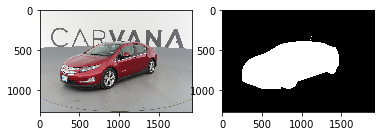

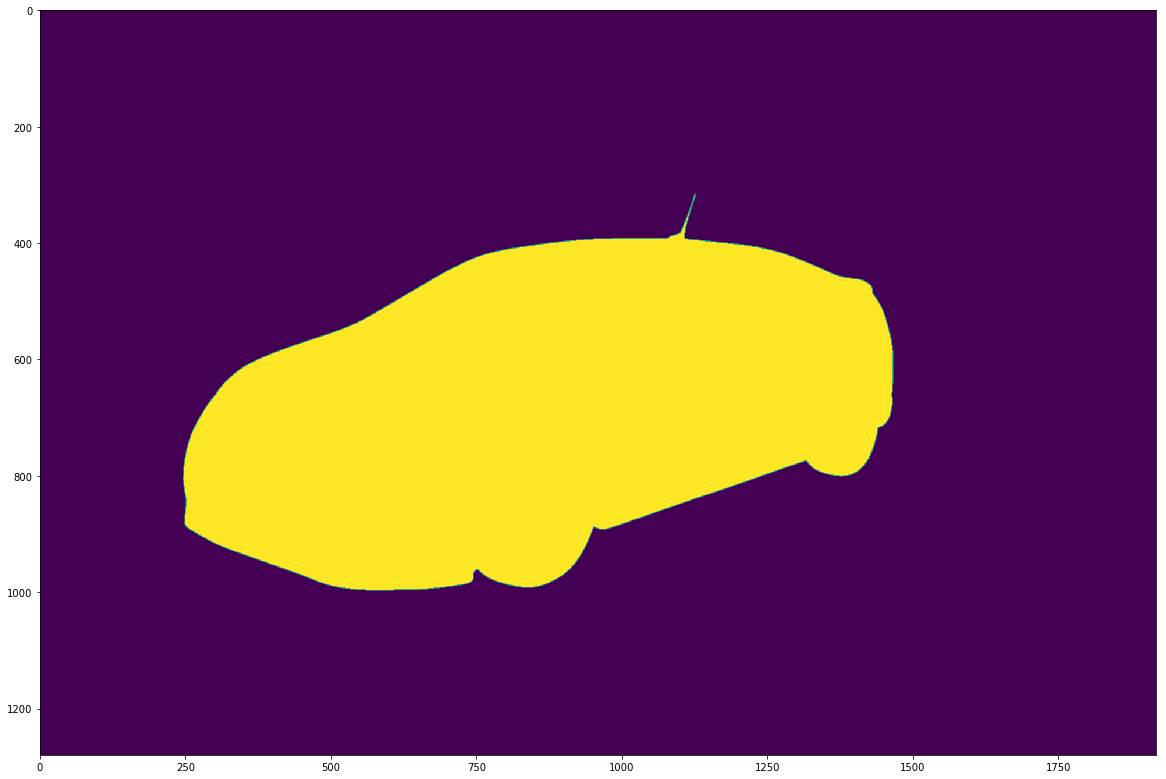

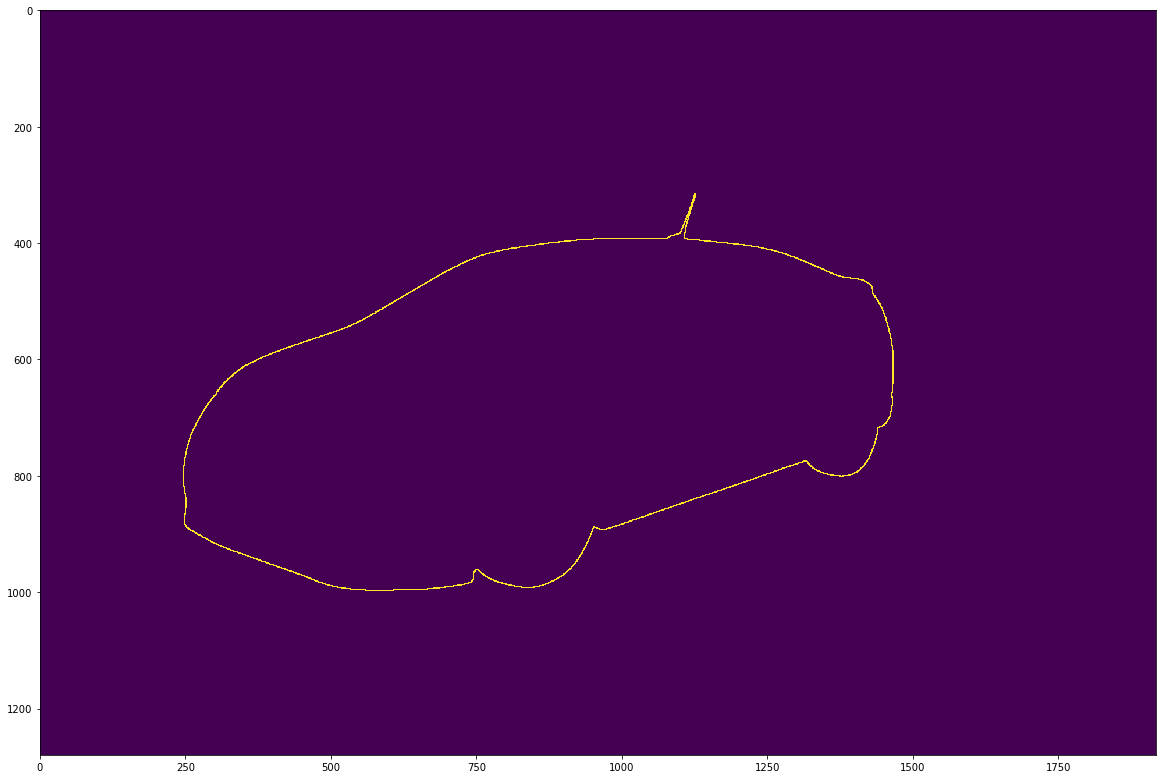

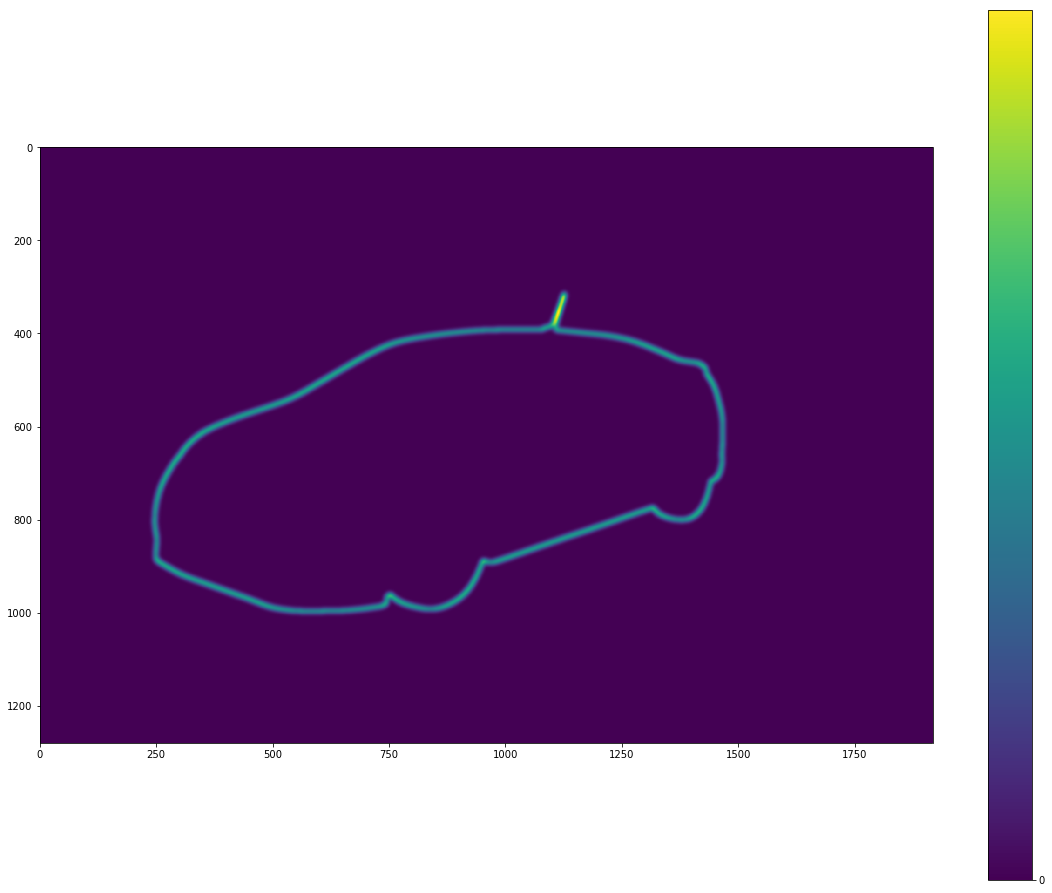

0.382574


In [30]:
def tf_detect_edge(y_true, kernel_size=3, verbose=0):
    y_true_round = tf.round(y_true)
    edge_detector = tf.reshape(shape=(kernel_size, kernel_size, 1, 1), 
                               tensor=tf.ones(kernel_size**2))
    y_true_conv = tf.nn.conv2d(y_true_round, edge_detector, (1,1,1,1), 
                               'SAME', name='edge_detector')
    y_true_conv = tf.round(y_true_conv)
    condition1 = tf.equal(y_true_conv, 0.)
    condition2 = tf.equal(y_true_conv, kernel_size**2.)
    condition = tf.logical_or(condition1, condition2)
    edge = tf.where(condition, 
                    tf.zeros_like(y_true_conv), tf.ones_like(y_true_conv))
    if verbose:
        return y_true_conv ,edge
    else:
        return edge

def tf_gaussian_blur(edge, sigma=5, max=1):
    from scipy.ndimage import gaussian_filter
    kernel = np.zeros((sigma*8+1, sigma*8+1))
    kernel[sigma*4, sigma*4] = 1
    kernel = gaussian_filter(kernel, sigma)

    kernel = tf.constant(dtype=tf.float32, value=kernel)
    kernel = tf.reshape(shape=(sigma*8+1, sigma*8+1, 1, 1), tensor=kernel)
    blurred = tf.nn.conv2d(edge, kernel, (1,1,1,1), 'SAME', name='blur')
    #blurred = tf.clip_by_value(blurred, 0, max)
    return blurred

def test_tf_blur(mask):
    ph_mask = tf.placeholder(dtype=tf.float32, shape=(None, None, None, None))
    y_true_conv, edge = tf_detect_edge(ph_mask, verbose=1)
    blurred = tf_gaussian_blur(edge)
    with tf.Session() as sess:
        out = sess.run([y_true_conv, edge, blurred], feed_dict={ph_mask: mask})
    np.savetxt('edge.txt', out[0][0][:,:,0])
    
    plt.figure(figsize=(20, 16))
    plt.imshow(out[0][0][:,:,0])
    plt.show()
    plt.figure(figsize=(20, 16))
    plt.imshow(out[1][0][:,:,0])
    plt.show()
    
    fig, ax = plt.subplots(figsize=(20, 16))
    cax = ax.imshow(out[2][0][:,:,0])
    cbar = fig.colorbar(cax, ticks=[0, 1])
    cbar.ax.set_yticklabels(['0', '1.0'])
    fig.savefig('10.jpg')
    plt.show()
    print(out[2].max())

image_, mask_ = read_image_and_mask(data_dir, mask_dir, validation_images[135])
show_image_and_mask(image_, mask_)
image_ = imresize(image_, image_size[::-1])
mask_ = imresize(mask_, image_size[::-1])
mask_ = img_to_array(mask_)
test_tf_blur(mask_[None,:,:,0][:,:,:,None]/255)

In [ ]:
def max_weight(mask_dir, images):
    ph_mask = tf.placeholder(dtype=tf.float32, shape=(None, None, None, None))
    y_true_conv, edge = tf_detect_edge(ph_mask, verbose=1)
    blurred = tf_gaussian_blur(edge)
    max_weights = []
    with tf.Session() as sess:
        for image in tqdm(images):
            mask = load_img(mask_dir + image.split('.')[0] + '_mask.gif')
            mask = img_to_array(mask)
            mask = mask[None,:,:,0][:,:,:,None] / 255
            out = sess.run([y_true_conv, edge, blurred], feed_dict={ph_mask: mask})
            max_weights.append(out[2].max())
    return max_weights

max_weights_ = max_weight(mask_dir, validation_images[:200])

 89%|████████▉ | 178/200 [00:23<00:02,  7.69it/s]

In [53]:
print (validation_images[135])

4f0397cf7937_09.jpg


200
0.164806
135


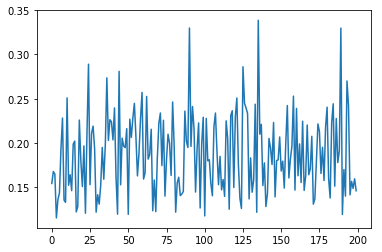

In [51]:
print (len(max_weights_))
print (max_weights_[2])
print (np.array(max_weights_).argmax())
plt.plot(max_weights_)
plt.show()

In [31]:
# Custome loss
def weighted_binary_crossentropy(y_true, y_pred):
    """
    # Args:
    y_true:      (batch_size, high, width, channel)
    """
    class_weight = 1
    epsilon = 1e-7
    y_pred = tf.clip_by_value(y_pred, epsilon, 1-epsilon)
    # Calculate weight
    edge = tf_detect_edge(y_true)
    blurred = tf_gaussian_blur(edge)
    boundry_weight = 200
    weight_map = 1 + (class_weight - 1) * y_true + boundry_weight * blurred
    crossentropy = - y_true * tf.log(y_pred) - (1 - y_true) * tf.log(1 - y_pred)
    weighted_loss = K.mean(crossentropy * weight_map, axis=-1)
    
    return weighted_loss

def test_weighted_loss():
    y_true = np.random.choice([0,1], size=(1,4,4,1))
    y_pred = np.random.uniform(size=(1,4,4,1))
    ph_true = tf.placeholder(dtype=tf.float32, shape=(None, None, None, None))
    ph_pred = tf.placeholder(dtype=tf.float32, shape=(None, None, None, None))
    op_loss = weighted_binary_crossentropy(ph_true, ph_pred)
    
    from keras.losses import binary_crossentropy
    op_naive_loss = binary_crossentropy(ph_true, ph_pred)
    with tf.Session() as sess:
        loss = sess.run([op_loss, op_naive_loss], feed_dict={ph_true: y_true, ph_pred: y_pred})
        print ('weigted loss')
        print (loss[0])
        print ('naive loss')
        print (loss[1])
        loss = sess.run(K.mean(K.binary_crossentropy(ph_true, ph_pred), axis=-1), 
                        feed_dict={ph_true: y_true, ph_pred: y_pred})
        print ('naive loss 2')
        print (loss)
        loss = sess.run(K.mean(-ph_true * tf.log(ph_pred) - (1 - ph_true) * tf.log(1 - ph_pred), axis=-1), 
                        feed_dict={ph_true: y_true, ph_pred: y_pred})
        print ('loss with prob 2')
        print (loss)
test_weighted_loss()

weigted loss
[[[ 20.78007317  17.84686661  35.48035812  40.65933228]
  [  1.93719006  36.03931046  16.53415871   7.02018547]
  [ 38.78920746  27.0821228   43.13148117   3.6505065 ]
  [ 47.44330215  10.2802       2.13966465   1.02650237]]]
naive loss
[[[ 1.18579447  0.9784829   1.93754601  2.29274154]
  [ 0.10620952  1.89873314  0.86784554  0.38060251]
  [ 2.11823893  1.42148745  2.25594187  0.19726461]
  [ 2.67528319  0.55734563  0.11562227  0.05731724]]]
naive loss 2
[[[ 1.18579447  0.9784829   1.93754601  2.29274154]
  [ 0.10620952  1.89873314  0.86784554  0.38060251]
  [ 2.11823893  1.42148745  2.25594187  0.19726461]
  [ 2.67528319  0.55734563  0.11562227  0.05731724]]]
loss with prob 2
[[[ 1.18579447  0.97848296  1.93754601  2.29274154]
  [ 0.10620954  1.89873314  0.86784554  0.38060251]
  [ 2.11823893  1.42148733  2.25594187  0.19726458]
  [ 2.67528319  0.55734563  0.1156223   0.05731724]]]


In [32]:
def threshold_mask(mask):
    mask[mask >= 0.5] = 1
    mask[mask < 0.5] = 0
    return mask

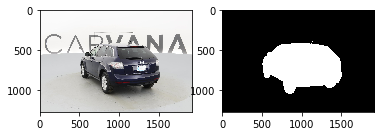

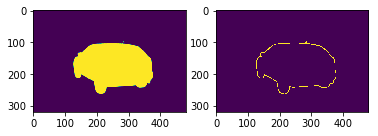

1a17a1bd648b_08.jpg


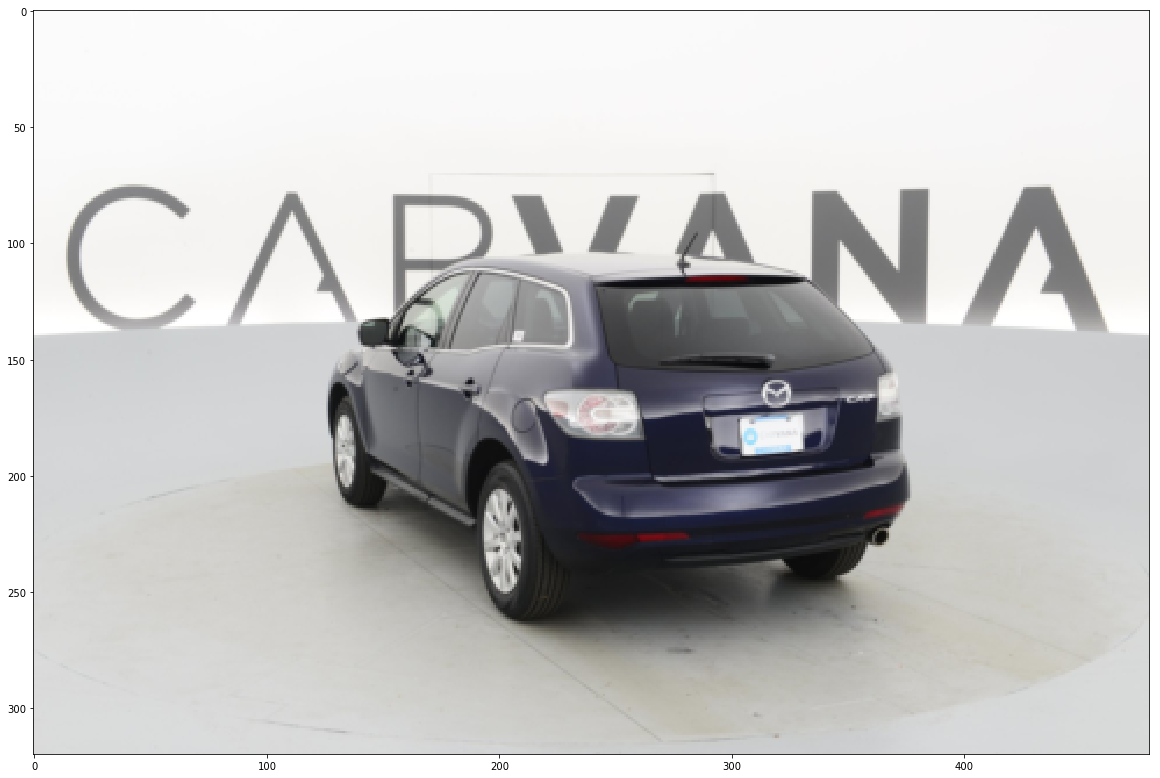

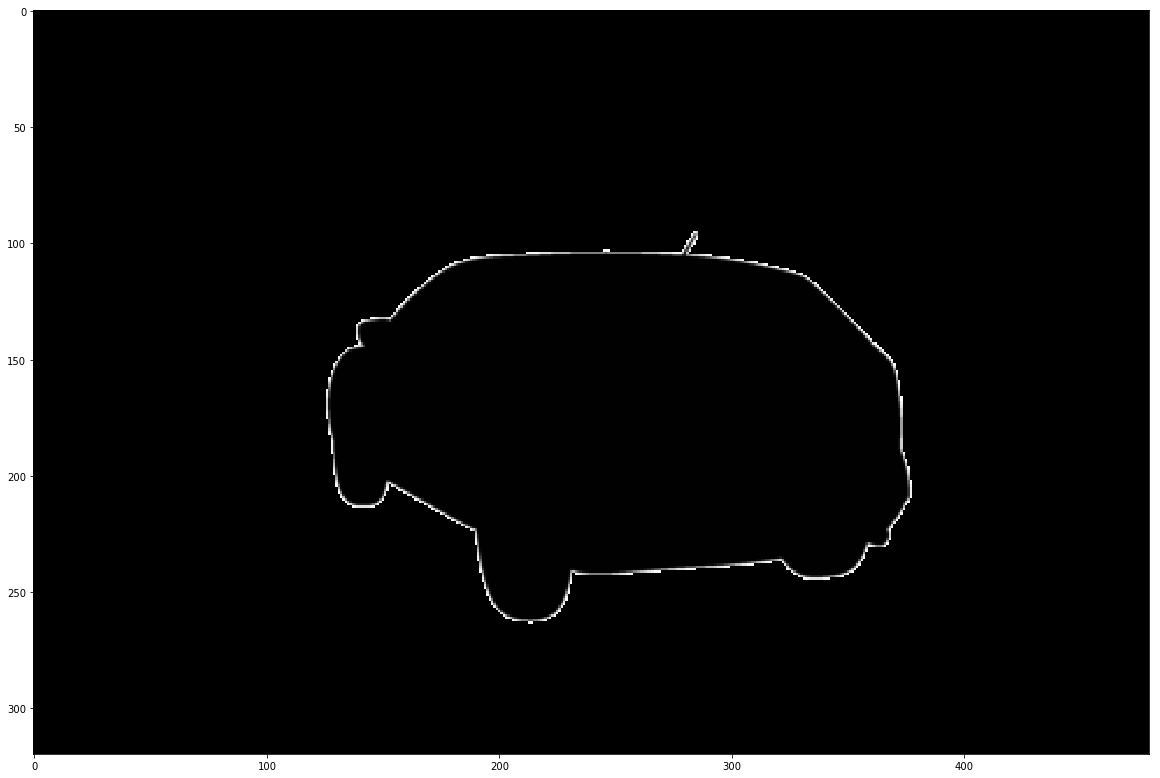

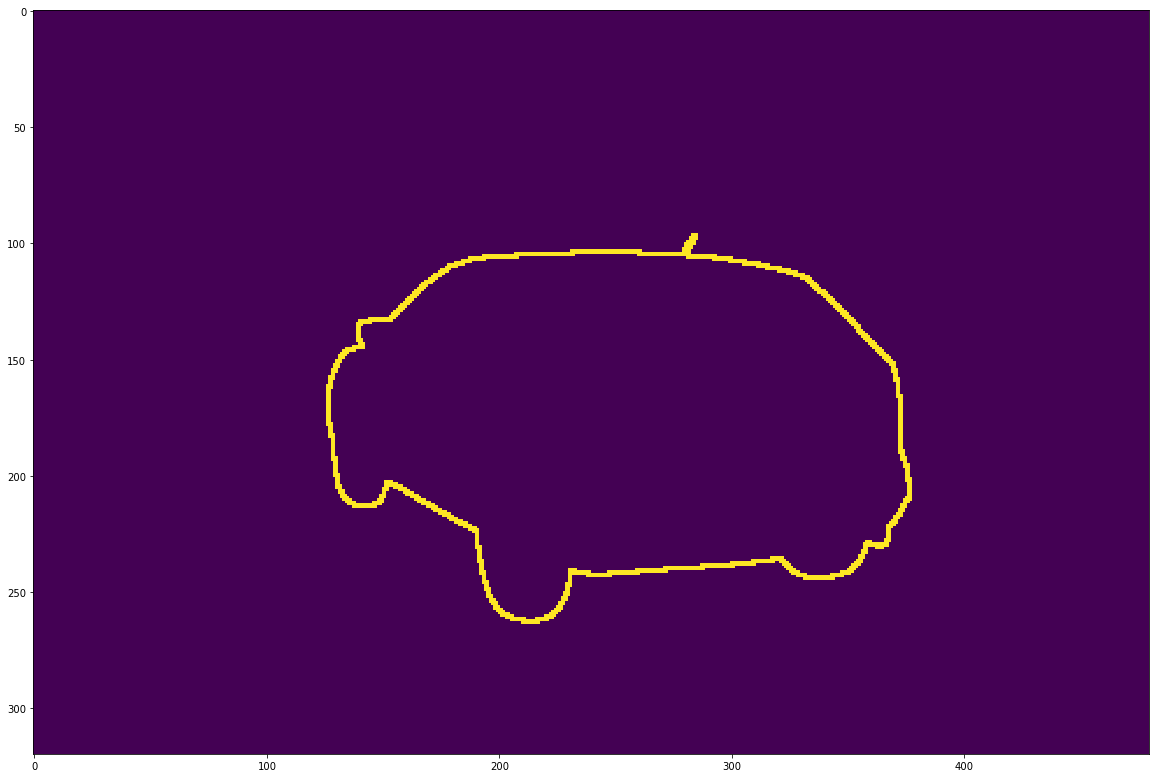

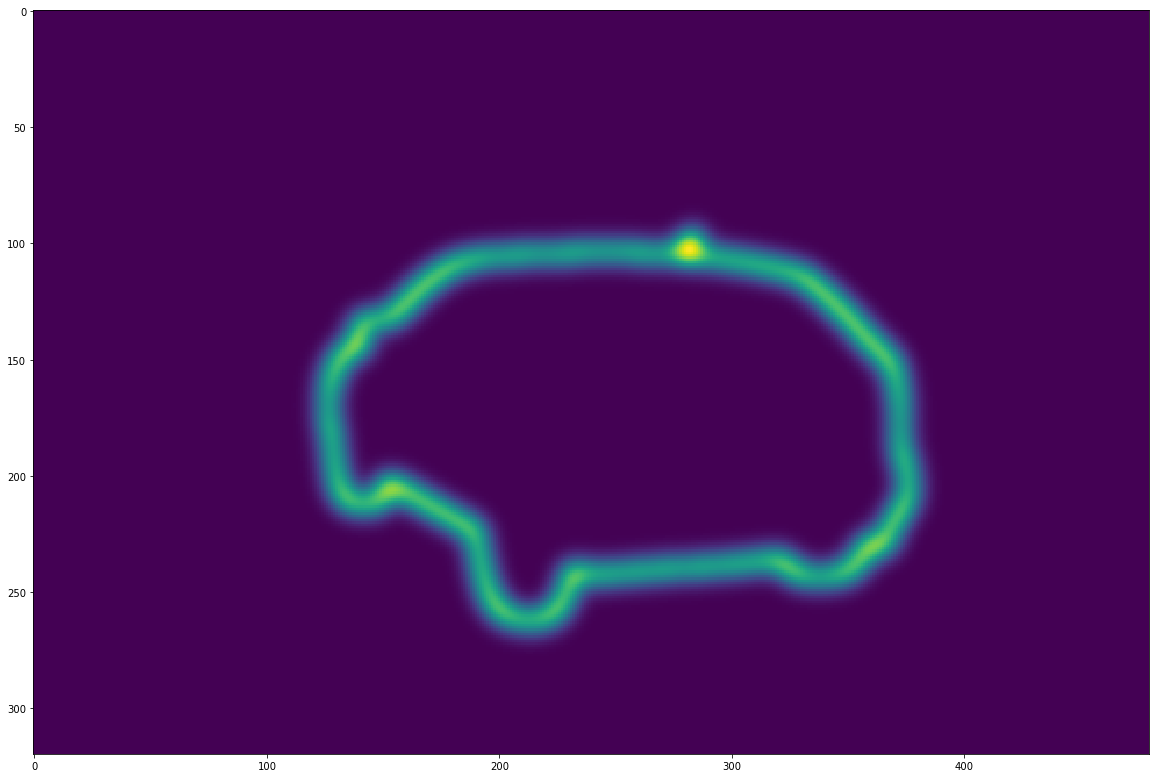

In [33]:
from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter
def detect_edge(mask, kernel_size=3, verbose=0):
    """
    # Args:
    mask:      2D array
    """
    edge_detector = np.ones(kernel_size**2).reshape((kernel_size, kernel_size))
    mask_conv = convolve2d(mask, edge_detector, 'same', 'symm')
    edge = np.ones_like(mask)
    if verbose:
        print ('show intermediate')
        plt.figure(figsize=(20, 16))
        plt.imshow(mask_conv)
        plt.show()
        np.savetxt('edge.txt', np.round(mask_conv))
    edge[mask_conv==0] = 0
    edge[mask_conv==kernel_size**2] = 0
    return edge
    
def gaussian_blur(mask, sigma=5):
    #return gaussian_filter(mask, 5)
    kernel = np.zeros((sigma*8+1, sigma*8+1))
    kernel[sigma*4, sigma*4] = 1
    kernel = gaussian_filter(kernel, sigma)
    blurred = convolve2d(mask, kernel, 'same', 'symm')
    return blurred

image_size = (480, 320)
image_, mask_ = read_image_and_mask(data_dir, mask_dir, validation_images[1])
show_image_and_mask(image_, mask_)
image_ = imresize(image_, image_size[::-1])
mask_ = imresize(mask_, image_size[::-1])
mask_ = img_to_array(mask_)
edge_ = detect_edge(threshold_mask(mask_[:,:,0]/255.))
show_image_and_mask(mask_[:,:,0], edge_)
#np.savetxt('edge.txt', threshold_mask(mask_[:,:,1]/255.))
print (validation_images[1])
plt.figure(figsize=(20, 16))
plt.imshow(image_)
plt.show()
plt.figure(figsize=(20, 16))
plt.imshow(mask_)
plt.show()
plt.figure(figsize=(20, 16))
plt.imshow(edge_)
plt.show()

edge_ = gaussian_blur(edge_)
plt.figure(figsize=(20, 16))
plt.imshow(edge_)
plt.show()

In [34]:
image_size = [1918, 1280]
input_dims = [1280, 1920]
batch_size = 1

In [44]:
%autoreload
# Model checkpoint
checkpoint = ModelCheckpoint(filepath=tmp_dir + 
                             'weights-epoch.hdf5', mode='max',
                             verbose=1, save_best_only=True, monitor='val_dice_coef')
csv_logger = CSVLogger(tmp_dir + 'training.log')
reduce_lr = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.2, patience=5, mode=max)
send_message = SendMessage(fexten=tmp_dir)
batch_history = BatchHistory(tmp_dir)
tensorboard = TensorBoard(log_dir='./log', write_grads=True, histogram_freq=1)

/home/paperspace/anaconda3/envs/tf11/lib/python3.6/site-packages/keras/callbacks.py:856: RuntimeWarning: Learning Rate Plateau Reducing mode <built-in function max> is unknown, fallback to auto mode.
  RuntimeWarning)


In [73]:
#optimizer = SGD(lr=0.001, momentum=0.99)
optimizer = SGD(lr=0.001, momentum=0.99)
model.compile(optimizer=optimizer, loss=weighted_binary_crossentropy, 
             metrics=[dice_coef])

In [74]:
# For keras 2.0.5, the max_queue_size should be max_q_size
# no relu in 2x2 conv, no advanced initializer
history = model.fit_generator(threadsafe_iter(train_gen), 
                              steps_per_epoch=2, 
                              callbacks=[checkpoint, csv_logger, batch_history], 
                              validation_data=(val_images[0:2], val_masks[0:2]), 
                              validation_steps=float('inf'), 
                              max_q_size=6, 
                              workers=1, 
                              epochs=2, 
                              initial_epoch=0)

Epoch 1/2
2/2 [==============================] - 6s - loss: 1.3503 - dice_coef: 0.3709 - val_loss: 1.0933 - val_dice_coef: 0.1686
Epoch 2/2
2/2 [==============================] - 4s - loss: 1.1543 - dice_coef: 0.0838 - val_loss: 1.0028 - val_dice_coef: 0.0012


In [ ]:
# For keras 2.0.5, the max_queue_size should be max_q_size
history = model.fit_generator(threadsafe_iter(train_gen), 
                              steps_per_epoch=4096 / batch_size, 
                              callbacks=[checkpoint, csv_logger, reduce_lr, batch_history, send_message], 
                              validation_data=val_gen, 
                              validation_steps=1018, 
                              max_q_size=6, 
                              workers=1, 
                              epochs=10, 
                              initial_epoch=0)

Start auto replying.


Epoch 1/10
  47/4096 [..............................] - ETA: 7318s - loss: 0.8141 - dice_coef: 0.6076

In [84]:
K.clear_session()
custom_objects = {'dice_coef': dice_coef, 
                  'weighted_binary_crossentropy': weighted_binary_crossentropy}
model = load_model(tmp_dir + 'weights-epoch.hdf5', custom_objects=custom_objects)

In [82]:
K.set_value(model.optimizer.lr, 0.0003)

In [ ]:
# For keras 2.0.5, the max_queue_size should be max_q_size
history = model.fit_generator(threadsafe_iter(train_gen), 
                              steps_per_epoch=4096 / batch_size, 
                              callbacks=[checkpoint, csv_logger, reduce_lr, batch_history, send_message], 
                              validation_data=val_gen, 
                              validation_steps=1018, 
                              max_q_size=6, 
                              workers=1, 
                              epochs=20, 
                              initial_epoch=10)

Start auto replying.


Epoch 11/20
 766/4096 [====>.........................] - ETA: 5878s - loss: 0.1042 - dice_coef: 0.9968

In [83]:
K.clear_session()
custom_objects = {'dice_coef': dice_coef, 
                  'weighted_binary_crossentropy': weighted_binary_crossentropy}
model = load_model(tmp_dir + 'weights-epoch.hdf5', custom_objects=custom_objects)

In [41]:
K.get_value(model.optimizer.lr)

4.0000003e-05

In [46]:
history = model.fit_generator(threadsafe_iter(train_gen), 
                              steps_per_epoch=20 / batch_size, 
                              callbacks=[checkpoint, csv_logger, reduce_lr, 
                                         batch_history, send_message, tensorboard], 
                              validation_data=val_gen, 
                              validation_steps=40, 
                              max_q_size=6, 
                              workers=1, 
                              epochs=18, 
                              initial_epoch=17)

Start auto replying.


Epoch 18/18
20/20 [==============================] - 65s - loss: 0.0926 - dice_coef: 0.9972 - val_loss: 0.1022 - val_dice_coef: 0.9968


In [ ]:
history = model.fit_generator(threadsafe_iter(train_gen), 
                              steps_per_epoch=4096 / batch_size, 
                              callbacks=[checkpoint, csv_logger, reduce_lr, send_message], 
                              validation_data=val_gen, 
                              validation_steps=1018, 
                              max_q_size=6, 
                              workers=1, 
                              epochs=50, 
                              initial_epoch=19)

In [ ]:
K.get_value(model.optimizer.lr)

In [ ]:
model.save('weights-best-in-52.hdf5')

In [ ]:
K.clear_session()
custom_objects = {'dice_coef': dice_coef, 
                  'weighted_binary_crossentropy': weighted_binary_crossentropy}
model = load_model('tmp-weights.hdf5', custom_objects=custom_objects)

In [ ]:
model.save('tmp-weights.hdf5')

In [ ]:
history = model.fit_generator(threadsafe_iter(train_gen), 
                              steps_per_epoch=4096 / batch_size, 
                              callbacks=[checkpoint, csv_logger, reduce_lr], 
                              validation_data=val_gen, 
                              validation_steps=1019, 
                              max_q_size=6, 
                              workers=1, 
                              epochs=81, 
                              initial_epoch=52)

In [35]:
custom_objects = {
    'dice_coef': dice_coef,
    'weighted_binary_crossentropy': weighted_binary_crossentropy
}

In [93]:
K.clear_session()
model = load_model('tmp/u-net-v5/w=200sigma=5/epoch20/weights-epoch.hdf5', 
                   custom_objects=custom_objects)

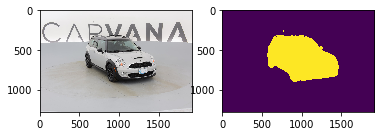

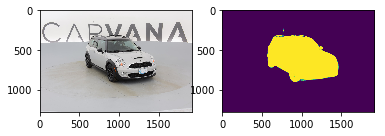

In [98]:
image_, mask_ = next(train_gen)
image_ = image_[0]
mask_ = mask_[0]
show_image_and_mask(image_, mask_[:,:,0])
mask_pred_ = model.predict(img_to_array(image_)[None,:,:,:])
show_image_and_mask(image_, mask_pred_[0,:,:,0])

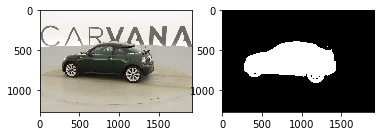

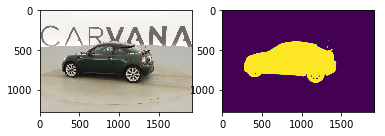

In [99]:
image_, mask_ = read_image_and_mask(data_dir, mask_dir, train_images[10])
show_image_and_mask(image_, mask_)
image_ = pad_image(image_, ((0, 0), (1, 1), (0, 0)))
mask_pred_ = model.predict(img_to_array(image_)[None,:,:,:] / 255)
show_image_and_mask(image_, mask_pred_[0,:,:,0])

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.2 µs


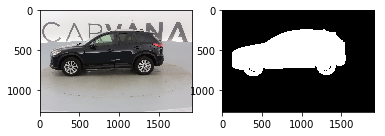

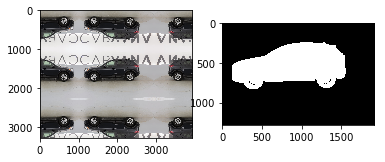

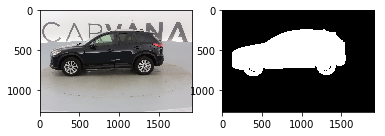

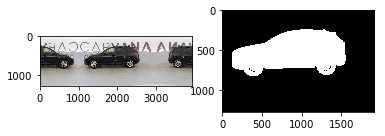

In [36]:
def pad_image(image, pad_width, mode='symmetric'):
    """
    Padding the image for prediction, the mode is 
    same as the one in numpy.pad
    
    # Args 
    image:      PIL Image or array
    pad_width:  the width to pad around the image, integer or tuple represent
                ((h, h), (w, w), (channel, channel))
    
    # Return
                PIL Image padded
    """
    array = img_to_array(image)
    if type(pad_width) is int:
        padding = ((pad_width, pad_width), (pad_width, pad_width), (0, 0))
    else:
        assert type(pad_width) in [tuple, list]
        padding = pad_width
    padded_array = np.pad(array, padding, mode=mode)
    padded_image = array_to_img(padded_array)
    return padded_image
%time
image_, mask_ = read_image_and_mask(data_dir, mask_dir, train_images[0])
show_image_and_mask(image_, mask_)
image_ = pad_image(image_, 1000)
show_image_and_mask(image_, mask_)

image_, mask_ = read_image_and_mask(data_dir, mask_dir, train_images[0])
show_image_and_mask(image_, mask_)
image_ = pad_image(image_, ((0, 0), (1000, 1000), (0, 0)))
show_image_and_mask(image_, mask_)

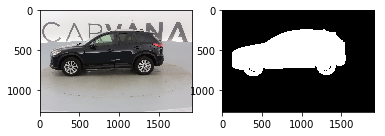

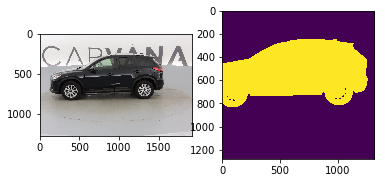

In [37]:
def cut_mask(mask, margin):
    
    ((cut_hs, cut_he), (cut_ws, cut_we), _) = margin
    mask = img_to_array(mask)
    assert len(mask.shape) == 3
    h, w, _ = mask.shape
    mask = mask[cut_hs:h-cut_he, cut_ws:w-cut_we]
    return mask

image_, mask_ = read_image_and_mask(data_dir, mask_dir, train_images[0])
show_image_and_mask(image_, mask_)
mask_ = cut_mask(mask_, ((0, 0), (300, 300), (0, 0)))
show_image_and_mask(image_, mask_[:,:,0]/255)

In [ ]:
# predict 1 patch 250ms

In [ ]:
def predict_on_patch(model, image, pad_width, mode, image_size, input_size, output_size, verbose=0):
    """
    Predict the mask patch by patch since the valid padding is used in train
    
    # Args:
    image:      PIL Image
    mode:       Method to pading the image. The same as np.pad
    image_size: The size to perform prediction, (w, h). e.g (906, 640)
    input_size: The size of image to feed into the network
    output_size:The output mask size, which is smaller than input because the edge of the 
                input is discard gradually
    
    """
    image = imresize(image, image_size[::-1])
    if pad_width != 0:
        image = pad_image(image, pad_width, mode)
    array = img_to_array(image) / 255
    mask = np.zeros(image_size[::-1])
    h, w = array.shape[0:2]
    mask_h, mask_w = mask.shape
    
    patch_width = output_size[0]
    patch_high = output_size[1]
    assert patch_width == patch_high, 'Output_size must be square'
    
    input_patch_width = input_size[0]
    input_patch_high = input_size[1]
    assert input_patch_width == input_patch_high, 'Input_size must be square'
    
    if verbose:
        plt.figure()
        plt.imshow(image)
        plt.show()
    
    # Function for judge the position of the patch
    def _is_last_col():
        return patch_width * i + input_patch_width > w
    def _is_last_row():
        return patch_high * j + input_patch_high > h
    
    # Predict patch by patch
    for i in range(int(np.ceil((w - input_patch_width) / patch_width)) + 1):
        for j in range(int(np.ceil((h - input_patch_high) / patch_high)) + 1):
            
            xs = i * patch_width
            xe = xs + input_patch_width
            ys = j * patch_high
            ye = ys + input_patch_high
            
            if (_is_last_row()):
                ys = h - input_patch_high - 1
                ye = h - 1
            if (_is_last_col()):
                xs = w - input_patch_width - 1
                xe = w - 1
                
            if verbose:
                print ('Now processing ({}, {}), ({}, {}).'.
                       format(xs, ys, xe, ye))
            
            # Predict the patch
            patch = array[ys:ye, xs:xe]
            patch = patch[None,:,:,:]
            output_patch = model.predict(patch, batch_size=1)
            
            if verbose:
                show_image_and_mask(patch[0], output_patch[0,:,:,0])
            
            # Fill the mask
            xs = i * patch_width
            xe = (i + 1) * patch_width
            ys = j * patch_high
            ye = (j + 1) * patch_high
            if (_is_last_row()):
                ys = mask_h - patch_high - 1
                ye = mask_h - 1
            if (_is_last_col()):
                xs = mask_w - patch_width - 1
                xe = mask_w - 1
            mask[ys:ye, xs:xe] = output_patch[0,:,:,0]
            
    return mask

image_, mask_ = read_image_and_mask(data_dir, mask_dir, validation_images[0])
show_image_and_mask(image_, mask_)
image_ = imresize(image_, image_size[::-1])
mask_ = imresize(mask_, image_size[::-1])

output_dims = (1280, 1280)
%timeit mask_pred_ = predict_on_patch(model, image_, 0, 'symmetric',image_size, input_dims, output_dims)
mask_pred_[mask_pred_>0.5] = 1
mask_pred_[mask_pred_<0.5] = 0
show_image_and_mask(mask_, mask_pred_)

In [ ]:
image_, mask_ = read_image_and_mask(data_dir, mask_dir, validation_images[1])
show_image_and_mask(image_, mask_)
image_ = imresize(image_, image_size[::-1])
mask_ = imresize(mask_, image_size[::-1])

# Symmetric padding, (mirror)
mask_pred_ = predict_on_patch(model, image_, 0, 'symmetric',image_size, input_dims, output_dims)
mask_pred_[mask_pred_>0.5] = 1
mask_pred_[mask_pred_<0.5] = 0
show_image_and_mask(mask_, mask_pred_)

In [ ]:
image_, mask_ = read_image_and_mask(data_dir, mask_dir, validation_images[2])
show_image_and_mask(image_, mask_)
image_ = imresize(image_, image_size[::-1])
mask_ = imresize(mask_, image_size[::-1])

mask_pred_ = predict_on_patch(model, image_, 0, 'symmetric',image_size, input_dims, output_dims)
mask_pred_[mask_pred_>0.5] = 1
mask_pred_[mask_pred_<0.5] = 0
show_image_and_mask(mask_, mask_pred_)

In [ ]:
mask_pred_ = model.predict(val_images[0][None,:,:,:])
mask_pred_[mask_pred_>0.5] = 1
mask_pred_[mask_pred_<0.5] = 0
show_image_and_mask(val_masks[0][:,:,0], mask_pred_[0,:,:,0])

In [ ]:
def mirror_average_prediction(model, image, pad_width, mode, image_size, input_size, output_size):
    threshold = None
    image2 = image.transpose(Image.FLIP_LEFT_RIGHT)
    mask = predict_on_patch(model, image, pad_width, mode, image_size, input_size, output_size)
    mask2 = predict_on_patch(model, image2, pad_width, mode, image_size, input_size, output_size)
    mask = mask + np.fliplr(mask2)
    mask /= 2.
    if threshold:
        mask[mask>=threshold] = 1
        mask[mask<threshold] = 0
    return mask
image_, mask_ = read_image_and_mask(data_dir, mask_dir, validation_images[2])
show_image_and_mask(image_, mask_)
mask_ = imresize(mask_, image_size[::-1])
%timeit mask_pred_ = mirror_average_prediction(model, image_, 0, 'edge', image_size, input_dims, output_dims)
show_image_and_mask(mask_, mask_pred_)

In [ ]:
%%time
def pad_mirror_prediction(model, image, pad_width, mode):
    threshold = None
    image = pad_image(image, pad_width, mode=mode)
    image2 = image.transpose(Image.FLIP_LEFT_RIGHT)
    
    image = img_to_array(image) / 255
    image2 = img_to_array(image2) / 255
    
    images = np.array([image, image2])
    masks = model.predict(images)
    mask = masks[0] + np.fliplr(masks[1])
    mask /= 2
    mask = cut_mask(mask, pad_width)
    if threshold:
        mask[mask>=threshold] = 1
        mask[mask<threshold] = 0
    return mask

image_, mask_ = read_image_and_mask(data_dir, mask_dir, validation_images[1])
show_image_and_mask(image_, mask_)
image_ = img_to_array(image_)
mask_pred_ = pad_mirror_prediction(model, image_, ((0, 0),(1, 1),(0, 0)), \
                                           'symmetric')
show_image_and_mask(mask_, mask_pred_[:,:,0])

In [119]:
mask_pred_.max()

1.0

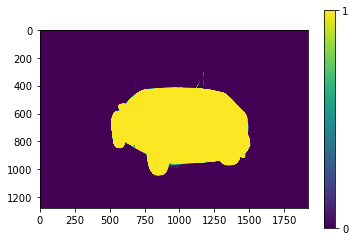

In [120]:
fig, ax = plt.subplots()

cax = ax.imshow(mask_pred_[:,:,0])
cbar = fig.colorbar(cax, ticks=[-1, 0, 1])

plt.show()

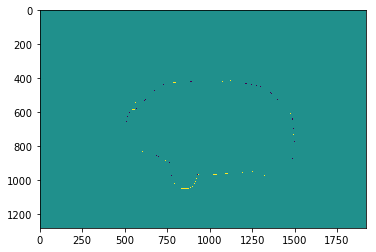

In [121]:
plt.figure()
plt.imshow(img_to_array(mask_)[:,:,0] / 255. - threshold_mask(mask_pred_[:,:,0]))
plt.show()
# Yellow: indicate fasle negtive
# Purper: indicate fasle positve

In [ ]:
def cal_dice_coef(mask1, mask2):
    """
    calculate dice coefficient
    
    mask1:    Groundtruth lable, size + channel
    mask2:    Predicted lable, 
    """
    
    if mask1.max() > 1:
        mask1 = (mask1 / 255.)[:,:,0]
    mask1 = mask1.astype(int)
    threshold = 0.5
    if threshold:
        mask2[mask2>=threshold] = 1
        mask2[mask2<threshold] = 0
        mask2 = mask2.astype(int)
    intersection = mask1 * mask2
    return 2. * intersection.sum() / (mask1 + mask2).sum()
%time cal_dice_coef((img_to_array(mask_)/255)[:,:,0], mask_pred_[:,:,0])

In [42]:
from data_utils import show_3_images, show_4_images

In [ ]:
# Calculate the dice coefficient on the validation set. The mask is smaller than the image.
def val_dice_coef(model, image_pairs, 
                  pad_width, image_size, input_size, output_size, val_step=0):
    dices = []
    if val_step == 0:
        assert len(image_pair) == 2, 'Image_pair should be a tuple.'
        images, masks = image_pairs
        for image, mask in tqdm(zip(images, masks)):
            mask_pred = model.predict(image[None,:,:,:])
            mask_pred = mask_pred[0,:,:,:]
            dice = cal_dice_coef(mask, mask_pred)
            dices.append(dice)
            # Show image, mask, prediction and difference
            show_4_images(image, mask[:,:,0], mask_pred[:,:,0], 
                          mask[:,:,0]-mask_pred[:,:,0])
    else:
        for i in tqdm(range(val_step)):
            val_images, val_masks = next(val_gen)
            mask_preds = model.predict(val_images)
            for image, mask, mask_pred in zip(val_images, val_masks, mask_preds):
                dice = cal_dice_coef(mask, mask_pred)
                dices.append(dice)
                show_4_images(image, mask[:,:,0], mask_pred[:,:,0], 
                              mask[:,:,0]-mask_pred[:,:,0])
    return dices

val_gen = data_gen_small(data_dir, mask_dir, validation_images, batch_size, 
                         input_dims, transforms=transforms, in_order=True)
dices = val_dice_coef(model, val_gen, 0, image_size, input_dims, \
                      output_dims, val_step=1018)

In [140]:
np.mean(dices)

0.99687875796781233

In [ ]:
def remove_artifacts(mask):
    """
    # Args:
     mask:      2D array
    """
    mask = np.round(mask)
    mask = mask.astype(np.int32)
    label = label_shape(mask, connectivity=2)
    
    (h, w) = mask.shape
    bottom_left = label[h-1,0]
    bottom_right = label[h-1,w-1]
    if bottom_left == bottom_right and bottom_left != 0:
        # Remove bottom blob
        mask[label==bottom_left] = 0
    label[label==bottom_left] = 0
    # Remove other small area
    label_num = label.max()
    areas = [(label == i + 1).sum() for i in range(label_num + 1)]
    areas_max = max(areas)
    # retain the largest blob, remove all other blobs
    for i in range(1, label_num + 1):
        if areas[i-1] != areas_max:
            mask[label==i] = 0
    return mask

ix_ = np.random.randint(0, 1018)
image_, mask_ = read_image_and_mask(data_dir, mask_dir, validation_images[ix_])
show_image_and_mask(image_, mask_)
image_ = imresize(image_, image_size[::-1])
mask_ = imresize(mask_, image_size[::-1])

mask_pred_ = predict_on_patch(model, image_, 0, 'edge',image_size, input_dims, output_dims)
mask_pred_[mask_pred_>0.5] = 1
mask_pred_[mask_pred_<0.5] = 0
show_3_images(mask_, mask_pred_, mask_[:,:,0] / 255. - mask_pred_)

mask_processed_ = remove_artifacts(mask_pred_)

plt.figure(figsize=(16, 12))
plt.imshow(mask_pred_)
plt.show()
plt.figure(figsize=(16, 12))
plt.imshow(mask_processed_)
plt.show()

In [ ]:
ix_ = np.random.randint(0, 1018)
print (validation_images[ix_])
image_, mask_ = read_image_and_mask(data_dir, mask_dir, validation_images[ix_])
show_image_and_mask(image_, mask_)
image_ = imresize(image_, image_size[::-1])
mask_ = imresize(mask_, image_size[::-1])

%timeit mask_pred_ = predict_on_patch(model, image_, 0, 'edge',image_size, input_dims, output_dims)
mask_pred_[mask_pred_>0.5] = 1
mask_pred_[mask_pred_<0.5] = 0

plt.figure(figsize=(16, 12))
plt.imshow(image_)
plt.show()
plt.figure(figsize=(16, 12))
plt.imshow(mask_)
plt.show()
plt.figure(figsize=(16, 12))
plt.imshow(mask_pred_)
plt.show()
plt.figure(figsize=(16, 12))
plt.imshow(mask_[:,:,0] / 255. - mask_pred_)
plt.show()
# Yellow: indicate fasle negtive, should be mask but fail to detect
# Purper: indicate fasle positve, is not car but labeled as car

In [142]:
def sort_dices(dices, image_names):
    return sorted(dices), [image_name for _, image_name in sorted(zip(dices, image_names))]

dices_sort, validation_images_sort = sort_dices(dices, validation_images)

In [143]:
validation_images_sort[0]

'0d53224da2b7_13.jpg'

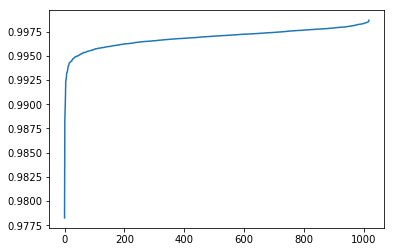

In [144]:
plt.figure()
plt.plot(dices_sort)
plt.show()

In [152]:
def show_diff(image, mask, mask_pred, save_to=None, show=True):
    plt.figure(figsize=(20, 16 * 5))
    plt.subplot(511)
    plt.imshow(image)
    plt.subplot(512)
    plt.imshow(mask)
    plt.subplot(513)
    plt.imshow(mask_pred)
    plt.subplot(514)
    plt.imshow(mask - mask_pred)
    plt.subplot(515)
    plt.imshow(image, alpha=0.6)
    plt.imshow(mask_pred, alpha=0.4)
    if save_to:
        plt.savefig(save_to)
    if show:
        plt.show()
    plt.close()

0d53224da2b7_13.jpg
0.978253870745


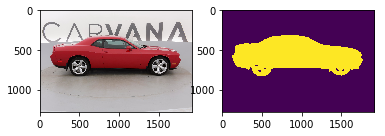

0.978005206774


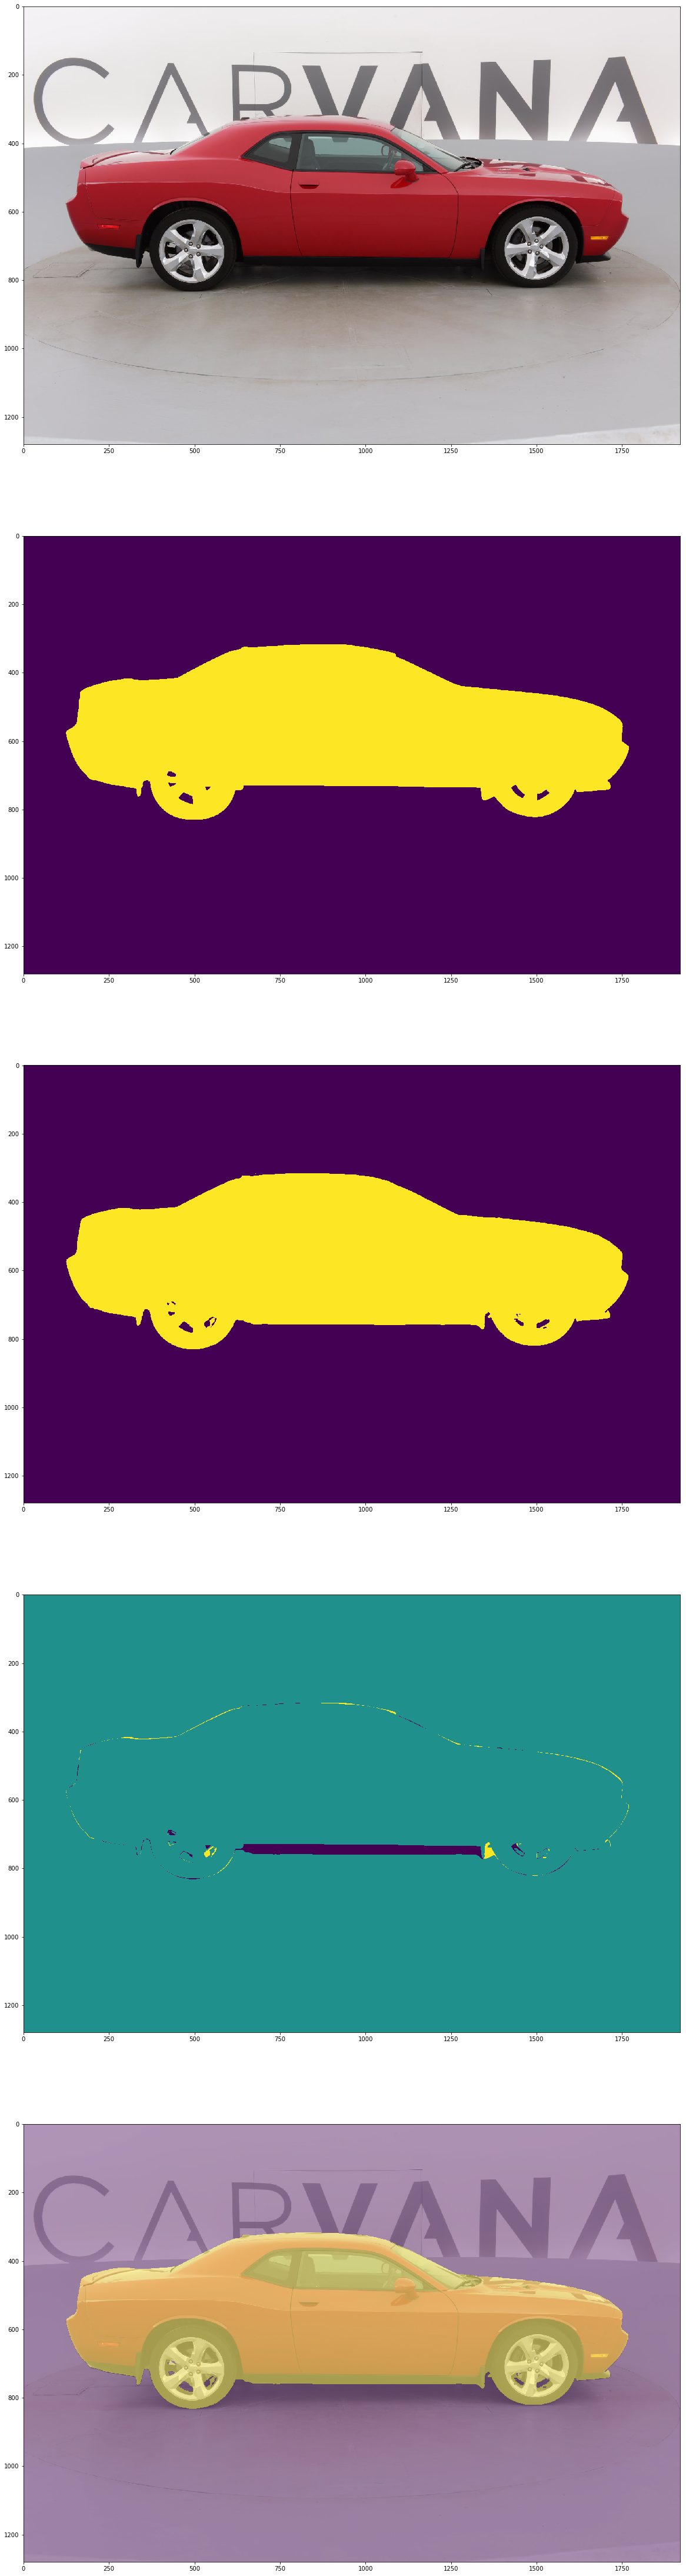

In [153]:
ix_ = 0
print (validation_images_sort[ix_])
print (dices_sort[ix_])

val_gen_ = data_gen_small(data_dir, mask_dir, [validation_images_sort[ix_]], 1, 
                         input_dims, transforms=transforms, in_order=True)
image_, mask_ = next(val_gen_)

show_image_and_mask(image_[0], mask_[0,:,:,0])

mask_pred_ = model.predict(image_)

print (cal_dice_coef(mask_[0], mask_pred_[0]))

mask_pred_[mask_pred_>0.5] = 1
mask_pred_[mask_pred_<0.5] = 0

show_diff(image_[0], mask_[0,:,:,0], mask_pred_[0,:,:,0], 
          save_to= tmp_dir + 'result/' + 'top-' + str(ix_ + 1) + '_error_' + validation_images_sort[ix_])
# Yellow: indicate fasle negtive, should be mask but fail to detect
# Purper: indicate fasle positve, is not car but labeled as car

0d53224da2b7_13.jpg
0.978253870745


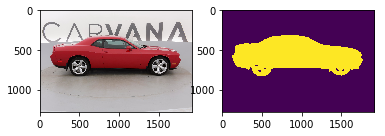

0.978005206774
bf9932f7aca8_13.jpg
0.988284534547


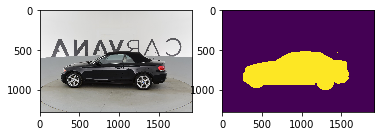

0.988284534547
b38c4e132183_09.jpg
0.98946959522


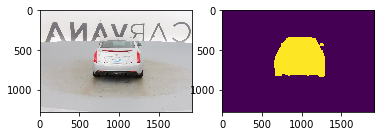

0.98946959522
6bff9e10288e_05.jpg
0.990707783268


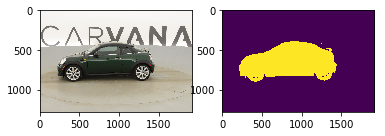

0.990601313329
ed13cbcdd5d8_08.jpg
0.99239600321


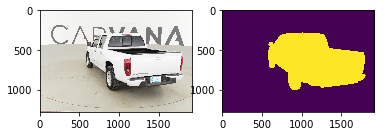

0.997154469254
34b0c08544a5_01.jpg
0.99251292076


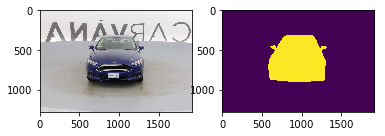

0.992517568617
5588758ee21c_09.jpg
0.992783060653


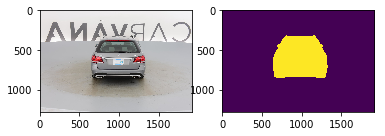

0.992843419412
f7ad86e13ed7_01.jpg
0.993166457389


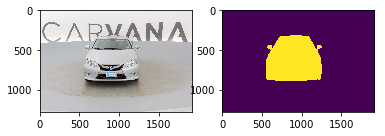

0.994187007351
2cb06c1f5bb1_09.jpg
0.993292473777


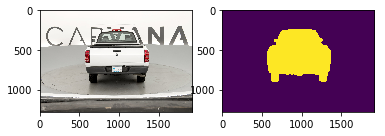

0.993292473777
4baf50a3d8c2_11.jpg
0.993316621479


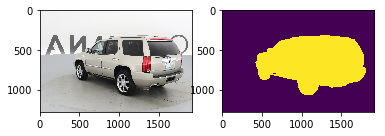

0.993316621479
86c10c8c6206_09.jpg
0.993486355805


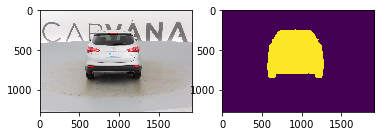

0.993486355805
56023a17481b_09.jpg
0.993676138358


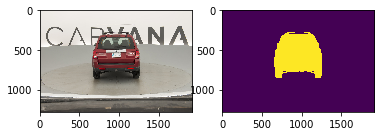

0.993676138358
7ab9747cf6d7_05.jpg
0.993927339964


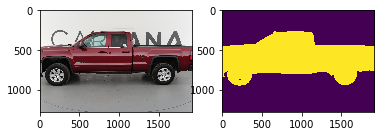

0.994214569729
de3ca5ec1e59_09.jpg
0.993980854301


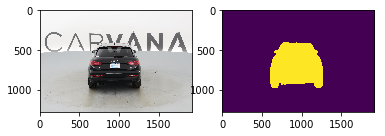

0.994373854632
ed13cbcdd5d8_12.jpg
0.994009366517


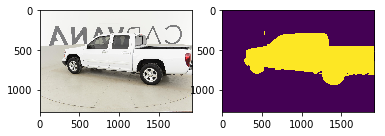

0.994009366517
9a2bfb24ba6e_11.jpg
0.994179627381


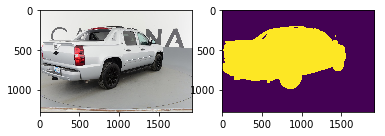

0.994946309022
d0dab700c896_09.jpg
0.994274193131


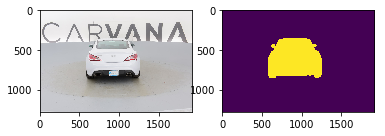

0.994030669355
fa006be8b6d9_12.jpg
0.994302687469


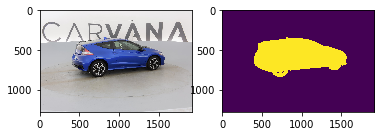

0.994302687469
3f8d611822bc_05.jpg
0.994341600191


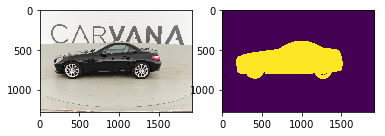

0.994341600191
c353e364e931_13.jpg
0.994369679664


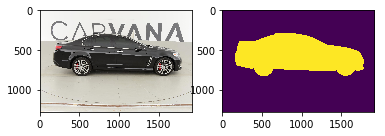

0.994369679664


In [154]:
def show_top_error(model, imin, imax, dices, validation_images_sort, 
                   input_dims, transforms, save=True, show=False):
    for ix_ in range(imin, imax):
        print (validation_images_sort[ix_])
        print (dices_sort[ix_])

        val_gen_ = data_gen_small(data_dir, mask_dir, [validation_images_sort[ix_]], 1, 
                                 input_dims, transforms=transforms, in_order=True)
        image_, mask_ = next(val_gen_)

        show_image_and_mask(image_[0], mask_[0,:,:,0])

        mask_pred_ = model.predict(image_)

        print (cal_dice_coef(mask_[0], mask_pred_[0]))

        mask_pred_[mask_pred_>0.5] = 1
        mask_pred_[mask_pred_<0.5] = 0

        save_to = (tmp_dir + 'result/' + 'top-' + str(ix_ + 1).zfill(3) + 
                '_error_' + validation_images_sort[ix_])
        
        show_diff(image_[0], mask_[0,:,:,0], mask_pred_[0,:,:,0], 
                  save_to=save_to, show=show)
# Yellow: indicate fasle negtive, should be mask but fail to detect
# Purper: indicate fasle positve, is not car but labeled as car
show_top_error(model, 0, 20, dices, validation_images_sort, 
               input_dims, transforms)

In [ ]:
# Calculate the dice coefficient on the validation set. The original image will be predict part by part.
# Calculate the dice coefficient on the validation set. The original image will be predict part by part.
def val_dice_coef2(model, validation_images, data_dir, mask_dir, 
                   pad_width, mode, image_size, input_size, output_size):
    dices = []
    masks_pred = []
    for image in tqdm(validation_images):
        image, mask = read_image_and_mask(data_dir, mask_dir, image)
        mask = imresize(mask, image_size[::-1]) / 255.
        mask_pred = mirror_average_prediction(model, image, 
                                               pad_width, mode, image_size, input_dims, output_dims)
        # Show image, mask, prediction and difference
        show_4_images(image, mask[:,:,0], mask_pred, mask[:,:,0]-mask_pred[:,:])
        dices.append(cal_dice_coef(mask[:,:,0], mask_pred))
    return dices
dices = val_dice_coef2(model, validation_images, data_dir, mask_dir,
                           0, 'edge', image_size, input_dims, output_dims)

In [ ]:
%lprun -f val_dice_coef2 val_dice_coef2(model, validation_images[0:10], data_dir, mask_dir, 0, 'edge', image_size, input_dims, output_dims)

In [ ]:
np.mean(dices)

In [ ]:
def val_dice_coef3(model, validation_images, data_dir, mask_dir, 
                   pad_width, mode, image_size, input_size, output_size):
    dices = []
    masks_pred = []
    for image in tqdm(validation_images):
        image, mask = read_image_and_mask(data_dir, mask_dir, image)
        mask = imresize(mask, image_size[::-1]) / 255.
        mask_pred = predict_on_patch(model, image, 0, 'edge',image_size, input_dims, output_size)
        # Show image, mask, prediction and difference
        show_4_images(image, mask[:,:,0], mask_pred, mask[:,:,0]-mask_pred)
        dices.append(cal_dice_coef(mask[:,:,0], mask_pred))
    return dices
dices = val_dice_coef3(model, validation_images, data_dir, mask_dir,
                           0, 'edge', image_size, input_dims, output_dims)

In [ ]:
np.mean(dices)
# This is smaller than mirrow average

In [44]:
test_images = os.listdir(test_dir)
len(test_images)

100064

In [46]:
test_images.sort()

In [47]:
test_images[0]

'0004d4463b50_01.jpg'

In [ ]:
%%time
image_ = load_img(test_dir + test_images[0])

In [48]:
def rle_encode(mask):
    pixels = mask.flatten()
    
    # Set begining and end to 0 for simplicity
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs [1::2] = runs[1::2] - runs[:-1:2]
    
    return runs

def rle_to_string(runs):
    return ' '.join(str(x) for x in runs)

def generate_one_record(image_names, mask): 
    rle_code = rle_encode(mask)
    record = image_names + ',' + rle_to_string(rle_code)
    return record

In [171]:
def make_net_v3():
    filters_list_1 = [36, 72, 144, 288]
    filters_list_2 = filters_list_1

    input_layer = Input(shape=[None, None, 3])
    out, residuals_1 = down_block(input_layer, filters_list_1)
    out, residuals_2 = down_block(out, filters_list_2)
    out = down(out, 64, pool=False)
    out = up_block(out, residuals_2, filters_list_2[::-1])
    out = up_block(out, residuals_1, filters_list_1[::-1])
    out = Conv2D(filters=1, kernel_size=(1, 1), kernel_initializer=he_normal(),
             activation='sigmoid', padding='same')(out)

    model = Model(input_layer, out)
    model.load_weights('tmp/u-net-v3/weights.hdf5')
    return model

In [ ]:
def generate_test(model, test_images, test_dir, pad_width, 
                  mode, image_size, input_size, output_size):
    
    report_per = 100
    
    progress_path_ensemble = tmp_dir + 'progress-ensemble.log'
    
    submission_path_v5 = tmp_dir + 'submission-v5.csv'
    
    K.clear_session()
    custom_objects = {'dice_coef': dice_coef, 
                      'weighted_binary_crossentropy': weighted_binary_crossentropy}
    model = load_model('tmp/u-net-v5/w=200sigma=5/epoch20/weights-epoch.hdf5', 
                       custom_objects=custom_objects)
    
    if os.path.isfile(submission_path_v5):
        os.remove(submission_path_v5)
    if os.path.isfile(progress_path_ensemble):
        os.remove(progress_path_ensemble)
    
    with open(submission_path_v5, 'w') as csvfile2:
        csvfile2.write('img,rle_mask\n')
        
    with open(submission_path_v5, 'a') as csvfile2:
        for i, image_name in enumerate(test_images):
            image = load_img(test_dir + image_name)
            #mask = mirror_average_prediction(model, image, 
            #                                      pad_width, mode, image_size, input_dims, output_dims)
            mask = pad_mirror_prediction(model, image, 
                                         ((0, 0), (1, 1), (0, 0)), 'symmetric')
            
            # v5 prediction
            mask = mask[:,:,0]
            csvfile2.write(generate_one_record(image_name, threshold_mask(mask)) + '\n')

            if i % report_per == 0:
                with open(progress_path_ensemble, 'w') as progress_file:
                    progress_file.write('progress is {}% \n'.format(i / len(test_images) * 100))
            
generate_test(model, test_images, test_dir, \
              0, 'edge', image_size, input_dims, output_dims)

/home/paperspace/anaconda3/envs/tf11/lib/python3.6/site-packages/keras/models.py:287: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [ ]:
#from data_utils import read_image
import data_utils
reload(data_utils)
#del globals()['read_image']
from data_utils import read_image, show_mask_on_image

#ix_ = random.randint(0, len(test_images))
image_ = read_image(test_dir, test_images[ix_])
image_ = array_to_img(img_to_array(image_) / 255)
plt.figure(figsize=(16, 12))
plt.imshow(image_)
plt.show()

mask_pred_ = mirror_average_prediction(model, image_, 0, 'edge', image_size, input_dims, output_dims)
mask_pred_ = threshold_mask(mask_pred_)

plt.figure(figsize=(16, 12))
plt.imshow(mask_pred_)
plt.show()

show_mask_on_image(image_, mask_pred_)

show_image_and_mask(image_, mask_pred_)
